In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split

# 前処理の方針(探索的データ分析)

- PassengerId(object)      : GroupNumber毎に、グループの人数に置き換え
- HomePlanet(object)       : OneHot
- CryoSleep(object)        : binary(0/1)で置き換える
- Cabin(object)            : 3つのカラムに分割(deck:OneHot or LabelEncoding/num:そのまま使用/side:binary化)
- Destination(object)      : OneHot
- Age(float64)             : 10歳毎にグループ化(子供[0-20]/大人[20-60]/老人[60-])
- VIP(object)              : binary(0/1)で置き換える
- RoomService(float64)     : FoodCourt,ShoppingMall,Spa,VRDeckのsumを一つのカラムとする(ServiceTotal)
- FoodCourt(float64)       : RoomService,ShoppingMall,Spa,VRDeckのsumを一つのカラムとする(ServiceTotal)
- ShoppingMall(float64)    : RoomService,FoodCourt,Spa,VRDeckのsumを一つのカラムとする(ServiceTotal)
- Spa(float64)             : RoomService,FoodCourt,ShoppingMall,VRDeckのsumを一つのカラムとする(ServiceTotal)
- VRDeck(float64)          : RoomService,FoodCourt,ShoppingMall,Spaのsumを一つのカラムとする(ServiceTotal)
- Name(object)             : 除外
- Transported(bool)        : binary(0/1)で置き換える
- ServiceTotal(float64)    : [RoomService,FoodCourt,ShoppingMall,Spa,VRDeck]の合計



# データ取得

In [2]:
# 訓練データの取得
train_df = pd.read_csv("s3://sagemaker-project-p-mbjujshffkps/inputdata/inputdata.csv")

# 前処理

In [3]:
# 
train_df["Transported"] = train_df["Transported"].astype(int)

In [4]:
train_df["GroupId"] = train_df["PassengerId"].str.split("_").str[0]
train_df["GroupSize"] = train_df.groupby("GroupId")["PassengerId"].transform("count")
train_df.drop(columns=["PassengerId", "GroupId"], inplace=True)

In [5]:
train_df.drop(columns=["Name"], inplace=True)

In [6]:
train_df["Age"] = train_df["Age"].fillna(-1)

def age_to_group(age):
    if age < 0:
        return "Unknown"
    elif age < 20:
        return "child"
    elif age < 60:
        return "adult"
    else:
        return "senior"

train_df["AgeGroup"] = train_df["Age"].apply(age_to_group)
train_df.drop(columns=["Age"], inplace=True)


In [7]:
service_cols = [
    "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"
]

train_df[service_cols] = train_df[service_cols].fillna(0)
train_df["ServiceTotal"] = train_df[service_cols].sum(axis=1)
train_df.drop(columns=service_cols, inplace=True)


In [8]:
train_df[["Deck", "CabinNum", "Side"]] = train_df["Cabin"].str.split("/", expand=True)
train_df.drop(columns=["Cabin"], inplace=True)

In [12]:
for col in ["CryoSleep", "VIP"]:
    train_df[col] = train_df[col].fillna(0)

In [10]:
categorical_cols = [
    "HomePlanet", "Destination", "Deck", "Side", "AgeGroup"
]

for col in categorical_cols:
    train_df[col] = train_df[col].fillna("Unknown")

train_df = pd.get_dummies(train_df, columns=categorical_cols)


In [11]:
train_df["CabinNum"] = pd.to_numeric(train_df["CabinNum"], errors="coerce")
train_df["CabinNum"] = train_df["CabinNum"].fillna(train_df["CabinNum"].median())

# データ分割

In [13]:
train, temp = train_test_split(
    train_df,
    test_size=0.3,
    random_state=42,
    stratify=train_df["Transported"]
)

validation, test = train_test_split(
    temp,
    test_size=0.5,
    random_state=42,
    stratify=temp["Transported"]
)

# モデル学習

In [14]:
import xgboost as xgb

In [15]:
y_train = train["Transported"]
X_train = train.drop(columns=["Transported"])

y_val = validation["Transported"]
X_val = validation.drop(columns=["Transported"])

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [17]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 5,
    "eta": 0.05,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
}

In [18]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=600,
    evals=[(dtrain, "train"), (dval, "validation")],
    early_stopping_rounds=50,
)

[0]	train-logloss:0.67753	validation-logloss:0.67883
[1]	train-logloss:0.66524	validation-logloss:0.66744
[2]	train-logloss:0.65195	validation-logloss:0.65510
[3]	train-logloss:0.63935	validation-logloss:0.64347
[4]	train-logloss:0.62835	validation-logloss:0.63352
[5]	train-logloss:0.61787	validation-logloss:0.62398
[6]	train-logloss:0.61507	validation-logloss:0.62116
[7]	train-logloss:0.60534	validation-logloss:0.61206
[8]	train-logloss:0.59664	validation-logloss:0.60421
[9]	train-logloss:0.58847	validation-logloss:0.59688
[10]	train-logloss:0.58579	validation-logloss:0.59426
[11]	train-logloss:0.57873	validation-logloss:0.58741
[12]	train-logloss:0.57553	validation-logloss:0.58451
[13]	train-logloss:0.56994	validation-logloss:0.57974
[14]	train-logloss:0.56404	validation-logloss:0.57429
[15]	train-logloss:0.55940	validation-logloss:0.57007
[16]	train-logloss:0.55347	validation-logloss:0.56486
[17]	train-logloss:0.54847	validation-logloss:0.56064
[18]	train-logloss:0.54343	validation-

# 評価

In [19]:
from sklearn.metrics import accuracy_score

y_test = test["Transported"]
X_test = test.drop(columns=["Transported"])

dtest = xgb.DMatrix(X_test)
y_prob = model.predict(dtest)
y_pred = (y_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.754601226993865

# 学習データとテストデータ統合

# 相関行列による変数の必要性検討

In [22]:
# 相関行列用データフレーム作成
new_train_df = all_df[~all_df['Transported'].isnull()].reset_index(drop=True)

<Axes: >

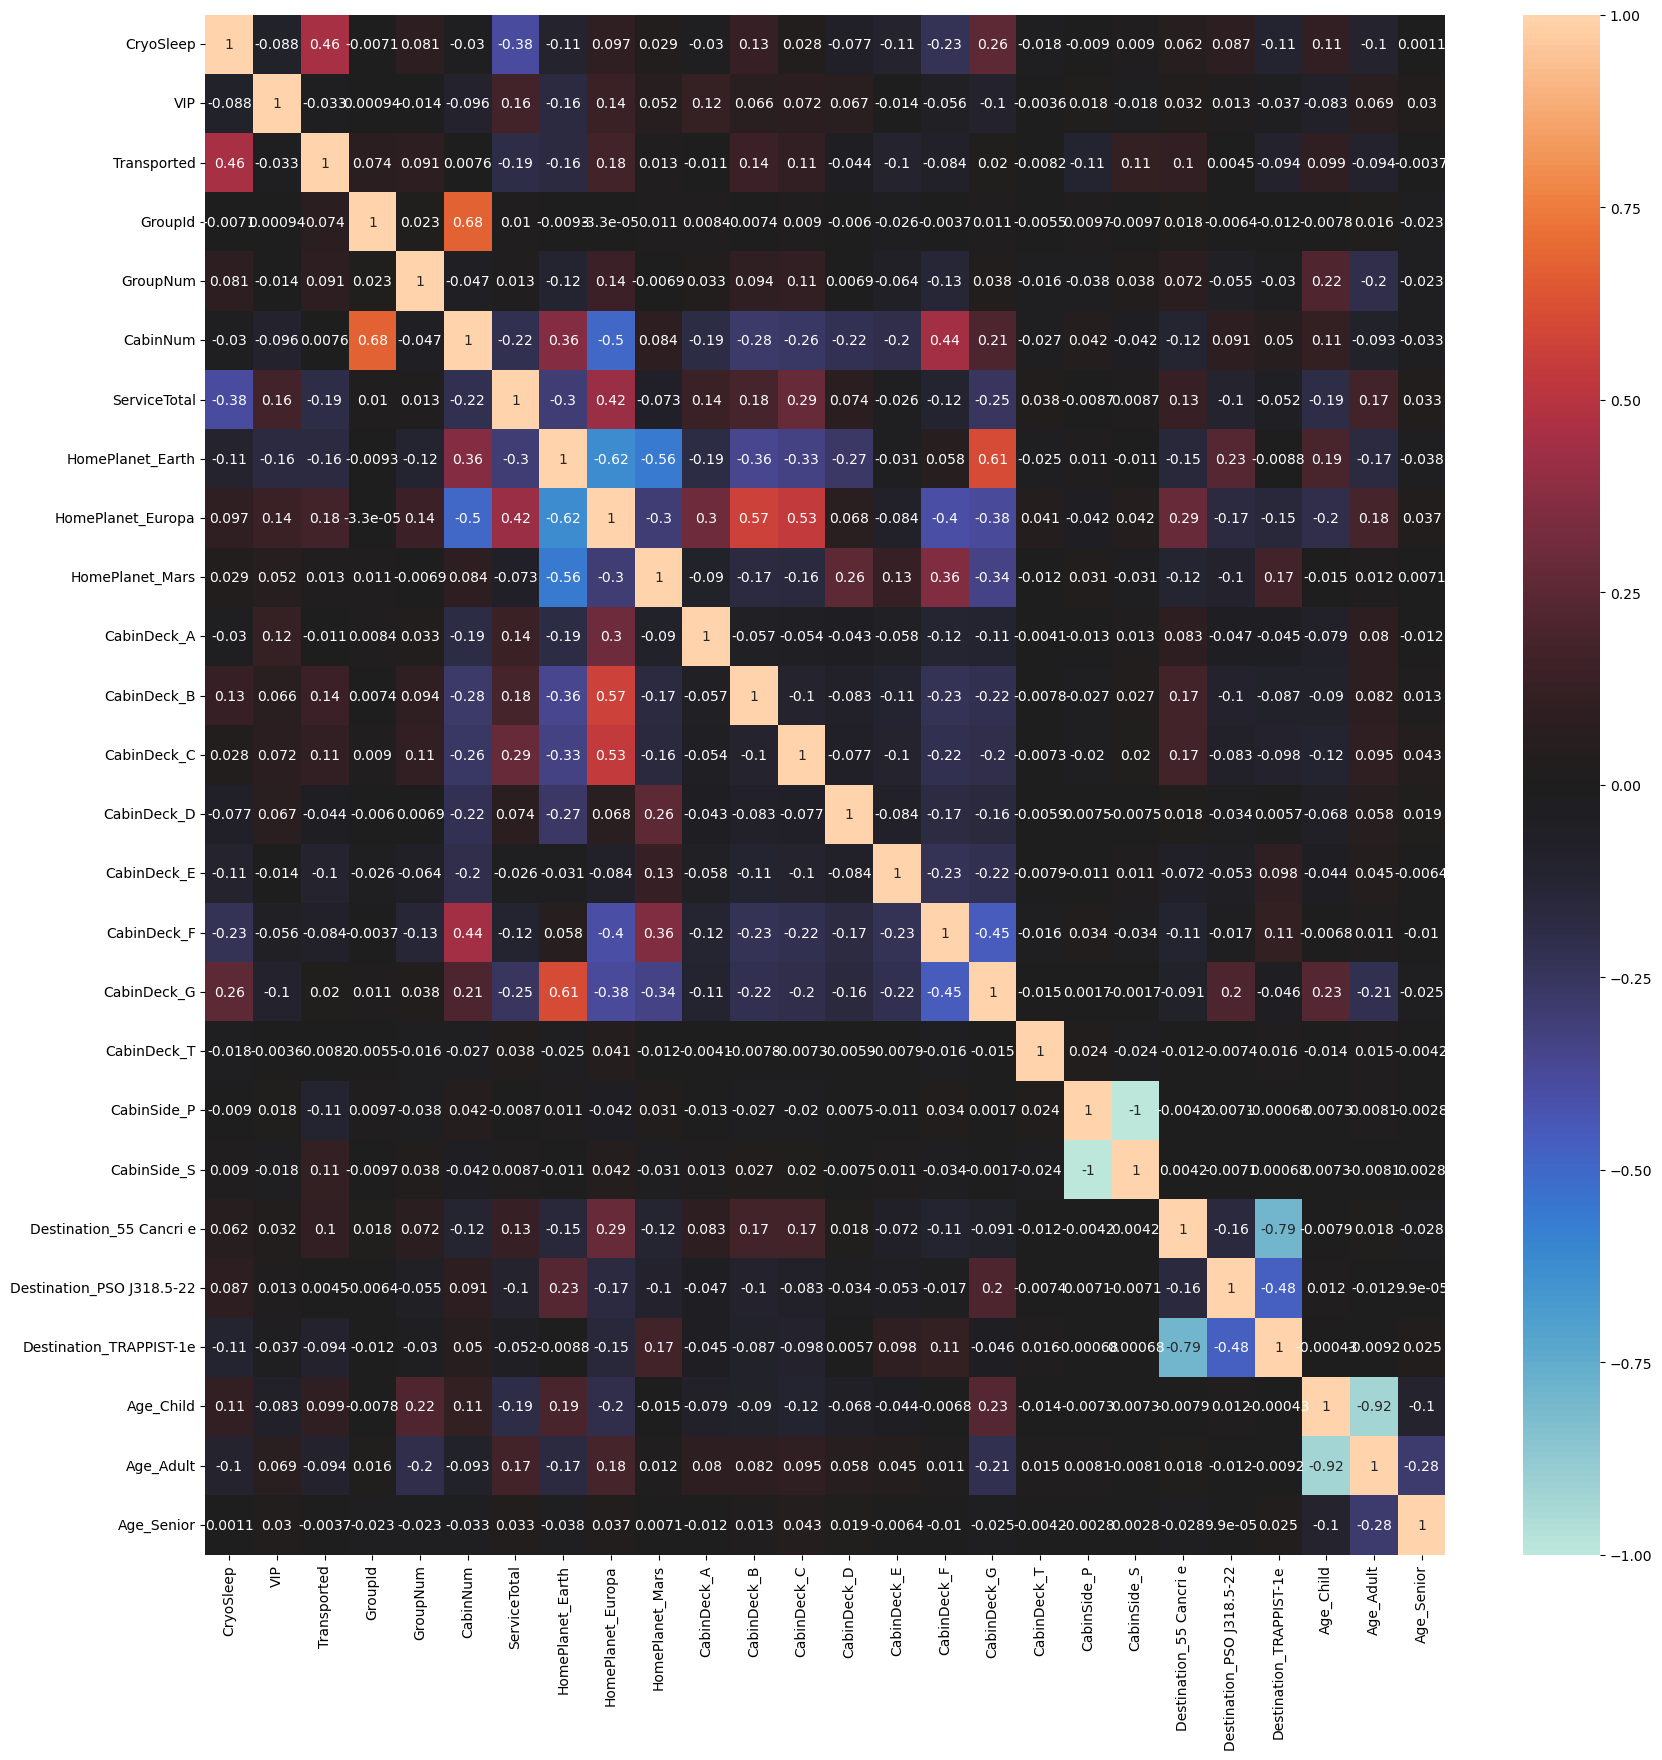

In [23]:
# 教師データの各カラム毎の相関行列をヒートマップで描画
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
train_corr = new_train_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0,annot=True)